In [1]:
import sys
sys.path.append('../../libmitigation')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time

In [3]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.ignis.mitigation as mit
import qiskit.quantum_info as qi
# from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter

In [6]:
sys.path.append("../../../../error_mitigation2021/sigqs03/libmitigation/")
import mitigation_tools
importlib.reload(mitigation_tools)
from mitigation_tools import MitigationTools
import inv_s_lm0_sgs, mooney_etal, nation_etal, inv_s_lstsq
importlib.reload(inv_s_lm0_sgs)
importlib.reload(mooney_etal)
importlib.reload(nation_etal)
importlib.reload(inv_s_lstsq)
from inv_s_lm0_sgs import InvSLM0SGS
from mooney_etal import MooneyEtal
from nation_etal import NationEtal
from inv_s_lstsq import InvSLstsq

In [7]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
from qiskit.result import Result
import importlib

In [8]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


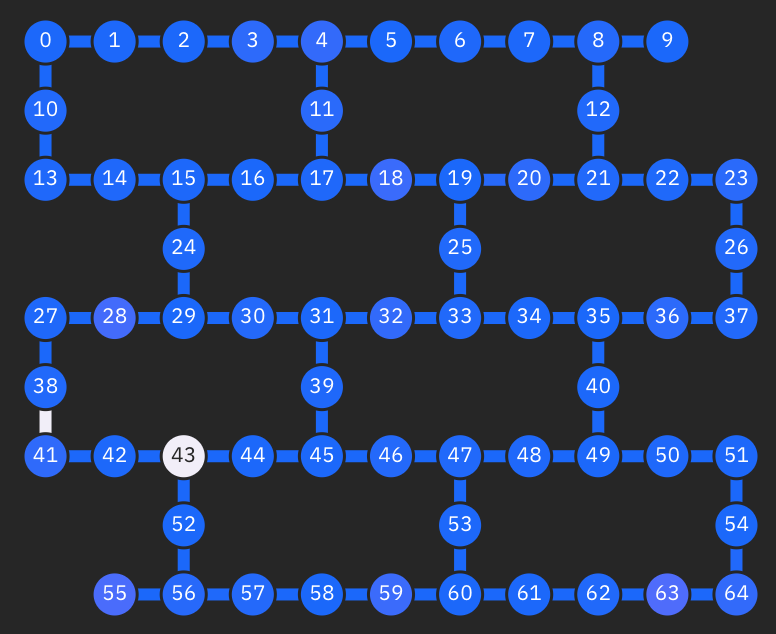

In [9]:
# qubit layout
vertex_list =  [33, # 0
                32, # 1
                25, 31, # 2, 3
                34, 19, 39, # 4, 5, 6
                30, 35, 18, 45, # 7, 8, 9, 10
                20, 29, 40, 17, 46, # 11, 12, 13, 14, 15
                36, 44, 21, 28, 49, 16, 47, # 16, 17, 18, 19, 20, 21, 22
                24, 11, 37, 43, 12, 27, 50, 15, 53, # 23, 24, 25, 26, 27, 28, 29, 30, 31
                22, 48,  4, 26, 52,  8, 38, 51, 14, 60, # 32, 33, 34, 35, 36, 37, 38, 39, 40, 41
                42, 23,  3, 56,  7, 41, 54, 13, 59, # 42, 43, 44, 45, 46, 47, 48, 49, 50
                 5,  9, 61,  2, 55,  6, 64, 10, 58, # 51, 52, 53, 54, 55, 56, 57, 58, 59
                57, 62,  1, 63,  0] # 60, 61, 62, 63, 64
def is_permutation(seq):
    return len(seq) == len(set(seq))
assert is_permutation(vertex_list)
max_size = len(vertex_list) # largest graph size
shots_per_circuit = 1 << 13 # shots per one execution
system_size = len(vertex_list)

In [10]:
print("max_size:", max_size)
print("system_size:", system_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 65
system_size: 65
shots_per_circuit: 8192


In [11]:
# indicate how to connect qubits
order = [[0,1], # 2
         [0,2],  [1,3], # 3
         [0,4],  [2,5],  [3,6], # 4
         [3,7],  [4,8],  [5,9],  [6,10], # 5
         [5,11], [7,12], [8,13], [9,14], [10,15], # 6
         [8,16], [10,17],[11,18],[12,19],[13,20],[14,21],[15,22], # 7
         [12,23],[14,24],[16,25],[17,26],[18,27],[19,28],[20,29],[21,30],[22,31], # 8
         [18,32],[20,33],[24,34],[25,35],[26,36],[27,37],[28,38],[29,39],[30,40],[31,41], # 9
         [26,42],[32,43],[34,44],[36,45],[37,46],[38,47],[39,48],[40,49],[41,50], # 10
         [34,51],[37,52],[41,53],[44,54],[45,55],[46,56],[48,57],[49,58],[50,59], # 11
         [45,60],[53,61],[54,62],[57,63],[58,64]] # 12

In [12]:
qubit_depths = [0, 
                1, 
                2, 2,
                3, 3, 3, 
                4, 4, 4, 4, 
                5, 5, 5, 5, 5, 
                6, 6, 6, 6, 6, 6, 6, 
                7, 7, 7, 7, 7, 7, 7, 7, 7,
                8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                9, 9, 9, 9, 9, 9, 9, 9, 9,
                10,10,10,10,10,10,10,10,10,
                11,11,11,11,11]
print(qubit_depths)
print(len(qubit_depths))

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11]
65


In [13]:
def ghz_state(size, order, qubit_depths):
    qc = QuantumCircuit(size)
    if size <= 1:
        qc.measure_all()
        return qc
    qc.h(0)
    depth = 0
    for i, j in order:
        if depth != qubit_depths[j]:
            qc.barrier()
            depth += 1
        qc.cx(i, j)
    qc.barrier()
    qc.measure_all()
    return qc

In [14]:
qcs = [ghz_state(size, order[:size-1], qubit_depths[:size]) for size in range(1, max_size+1)]

In [ ]:
for qc in qcs:
    print(qc.num_qubits)

In [ ]:
qcs[64].draw("mpl")

In [16]:
def make_qcs_list(qcs):
    qcs_list = []
    mit_patterns = []
    for i in range(len(qcs)):
        qr = QuantumRegister(qcs[i].num_qubits)
        mit_pattern = [[i] for i in range(qcs[i].num_qubits)]
        meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
        qcs_list.append(qcs[i])
        qcs_list += meas_calibs
        mit_patterns.append(mit_pattern)
    return qcs_list, mit_patterns

In [17]:
qcs_list, mit_patterns = make_qcs_list(qcs)
print(len(qcs_list), len(mit_patterns))

195 65


In [ ]:
for qc in qcs_list:
    print(qc.num_qubits)

In [ ]:
qcs_list[194].draw("mpl")

In [18]:
initial_layouts = []
for i in range(len(qcs_list)):
    initial_layouts.append( vertex_list[:qcs_list[i].num_qubits] )

In [19]:
# qc = transpile(qcs[-1], coupling_map=order, initial_layout=initial_layouts[-1])
# qc.draw("mpl")

In [19]:
device = provider.backends.ibmq_brooklyn
backend = provider.get_backend('ibmq_brooklyn')

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_6822/3224781028.py:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  device = provider.backends.ibmq_brooklyn


In [ ]:
initial_layouts

In [17]:
job = execute(qcs_list,
               backend=backend, 
               shots=shots_per_circuit,
               optimization_level=1,
               initial_layout=initial_layouts)
print("job id:", job.job_id())

job id: 612236919d8e994b6ff37708


In [ ]:
result = job.result()
print(len(result))

In [26]:
sys.path.append("../../libs")

In [29]:
import importlib
import lib_preprocessing
importlib.reload(lib_preprocessing)
from lib_preprocessing import job_ids_to_result, flatten_results_jobs_list, arrange_results_list_tensored3, results_list_to_counts_dict_list

In [30]:
job_ids = ["612236919d8e994b6ff37708"]
results_jobs_list = job_ids_to_result(job_ids, device)
print("length of results_jobs_list: ", len(results_jobs_list))
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
results_graph_states, results_meas_cal = arrange_results_list_tensored3(results_list)
print("length of results_meas_cal: ", len(results_meas_cal))


length of results_jobs_list:  1
length of results_list:  195
length of results_meas_cal:  65


In [31]:
counts_dict_list = results_list_to_counts_dict_list(results_graph_states)
print("length of counts_dict_list: ", len(counts_dict_list))
# del results_graph_states

length of counts_dict_list:  65


In [34]:
results_meas_cal[0]

Result(backend_name='ibmq_brooklyn', backend_version='1.2.13', qobj_id='26203d0c-7b82-4fb5-9319-42753ce85a5b', job_id='612236919d8e994b6ff37708', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 7990, '0x1': 202}), header=QobjExperimentHeader(clbit_labels=[['c0', 0]], creg_sizes=[['c0', 1]], global_phase=0.0, memory_slots=1, metadata={}, n_qubits=65, name='mcalcal_0', qreg_sizes=[['q', 65]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6], ['q', 7], ['q', 8], ['q', 9], ['q', 10], ['q', 11], ['q', 12], ['q', 13], ['q', 14], ['q', 15], ['q', 16], ['q', 17], ['q', 18], ['q', 19], ['q', 20], ['q', 21], ['q', 22], ['q', 23], ['q', 24], ['q', 25], ['q', 26], ['q', 27], ['q', 28], ['q', 29], ['q', 30], ['q', 31], ['q', 32], ['q', 33], ['q', 34], ['q', 35], ['q', 36], ['q', 37], ['q', 38], ['q', 39], ['q', 40], ['q', 41], ['q', 42], ['q', 43], ['q', 44], ['q', 45], ['q', 46], ['q', 47], [

In [35]:
ignis_mitigator_list = []
s_lm0_mitigator_list = []
mooney_mitigator_list = []
nation_mitigator_list = []
s_lstsq_mitigator_list = []
for n in range(1, max_size + 1):
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_fitter = TensoredMeasFitter(results_meas_cal[n - 1], mit_pattern=mit_pattern)
    print(len(meas_fitter.cal_matrices))
    ignis_mitigator_list.append(meas_fitter.filter)
    s_lm0_mitigator_list.append(InvSLM0SGS(n, meas_fitter.cal_matrices))
    mooney_mitigator_list.append(MooneyEtal(n, meas_fitter.cal_matrices))
    nation_mitigator_list.append(NationEtal(n, meas_fitter.cal_matrices))
    s_lstsq_mitigator_list.append(InvSLstsq(n, meas_fitter.cal_matrices))
print("length of ignis_mitigator_list: ", len(ignis_mitigator_list))
print("length of s_lm0_mitigator_list: ", len(s_lm0_mitigator_list))
print("length of mooney_mitigator_list: ", len(mooney_mitigator_list))
print("length of nation_mitigator_list: ", len(nation_mitigator_list))
print("length of s_lstsq_mitigator_list: ", len(s_lstsq_mitigator_list))
# del results_meas_cal


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
length of ignis_mitigator_list:  65
length of s_lm0_mitigator_list:  65
length of mooney_mitigator_list:  65
length of nation_mitigator_list:  65
length of s_lstsq_mitigator_list:  65


In [36]:
ignis_counts_list = []
s_lm0_counts_list = []
mooney_counts_list = []
nation_counts_list = []
scipy_counts_list = []

In [39]:
for i in range(len(results_meas_cal)):
    print(i + 1, "qubits")
    s_lm0_counts_list.append( s_lm0_mitigator_list[i].apply(counts_dict_list[i]) )
    print()

1 qubits
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 0
sum of mitigated probability vector x_hat_s: 0
number of positive values:  0
accumulator is positive, we might even ignoring the necessal positive values.
0.00031495094299316406 s
main process: Done!

2 qubits
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0000000000000002
sum of mitigated probability vector x_hat_s: 1.0005010268317347
number of positive values:  4
0.0005729198455810547 s
main process: Done!

3 qubits
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0000000000000004
sum of mitigated probability vector x_hat_s: 0.9983989709601915
number of positive values:  5
0.0007851123809814453 s
main process: Done!

4 qubits
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 0.9999999999999997
su

KeyboardInterrupt: 

In [41]:
s_lm0_counts_list

[{},
 {'10': 60.70175867649994,
  '01': 94.71913842774536,
  '00': 3979.072686341254,
  '11': 4057.5064165545},
 {'010': 112.79075887264374,
  '101': 182.80110062839933,
  '000': 3866.333903992851,
  '111': 4030.074236506106},
 {'1000': 1.183089254721681,
  '0100': 4.117116815814201,
  '0110': 7.292915089639724,
  '0111': 8.210701532244865,
  '1011': 21.67612651747646,
  '0101': 152.47895594390343,
  '1010': 173.6840649814268,
  '0000': 3893.8376811210037,
  '1111': 3929.5193487437696},
 {'00110': 9.152042443868236,
  '00100': 9.883754448801366,
  '01110': 12.252965904282519,
  '10001': 20.312334598246817,
  '11110': 26.72625498222823,
  '01111': 33.67735897043467,
  '10111': 54.883052811335375,
  '11011': 55.14024868003358,
  '10101': 159.29767246813114,
  '01010': 163.02469185215017,
  '11111': 3769.5122660520324,
  '00000': 3878.137356788455},
 {'110100': 0.0017694896156514872,
  '000100': 0.10826134328246173,
  '010101': 0.2419806962347213,
  '111110': 0.6608178183694022,
  '011010

In [42]:
for i in range(len(results_meas_cal[:29])):
    print(i + 1, "qubits")
    mooney_counts_list.append(
        mooney_mitigator_list[i].apply(counts_dict_list[i]))
    print()


1 qubits
The heuristcs by Mooney et al. + SGS algorithm
{}
sum of counts: 0
number of positive values:  0
accumulator is positive, we might even ignoring the necessal positive values.
0.00016307830810546875 s
main process: Done!

2 qubits
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.4861705253279005, 3: 0.4957762171570698}
sum of counts: 0.9819467424849704
number of positive values:  2
accumulator is positive, we might even ignoring the necessal positive values.
0.00032591819763183594 s
main process: Done!

3 qubits
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.4741803559410408, 7: 0.49394613399951953}
sum of counts: 0.9681264899405604
number of positive values:  2
accumulator is positive, we might even ignoring the necessal positive values.
0.0003077983856201172 s
main process: Done!

4 qubits
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.4773571902117597, 15: 0.48166584314424726}
sum of counts: 0.959023033356007
number of positive values:  2
accumulator is posit

In [43]:
for i in range(len(results_meas_cal[:29])):
    print(i + 1, "qubits")
    nation_counts_list.append(
        nation_mitigator_list[i].apply(counts_dict_list[i]))
    print()

1 qubits
Method by Nation, Kang, Sundaresan, and Gambatta
main process: Done!
sum of mitigated probability vector x: 0.0
start sgs_algorithm
number of positive values:  0
accumulator is positive, we might even ignoring the necessal positive values.
0.010951042175292969 s

2 qubits
Method by Nation, Kang, Sundaresan, and Gambatta
main process: Done!
sum of mitigated probability vector x: 0.9999999999999998
start sgs_algorithm
number of positive values:  3
0.0031762123107910156 s

3 qubits
Method by Nation, Kang, Sundaresan, and Gambatta
main process: Done!
sum of mitigated probability vector x: 1.0000016346326732
start sgs_algorithm
number of positive values:  6
0.0016498565673828125 s

4 qubits
Method by Nation, Kang, Sundaresan, and Gambatta
main process: Done!
sum of mitigated probability vector x: 0.9999991760122791
start sgs_algorithm
number of positive values:  10
0.004414796829223633 s

5 qubits
Method by Nation, Kang, Sundaresan, and Gambatta
main process: Done!
sum of mitigated

In [44]:
s_lm0_times = []
mooney_times = []
nation_times = []

In [45]:
for i in range(len(results_meas_cal[:29])):
    print(i + 1, "qubits")
    s_lm0_times.append(s_lm0_mitigator_list[i].time)
    mooney_times.append(mooney_mitigator_list[i].time)
    nation_times.append(nation_mitigator_list[i].time)
    print()


1 qubits

2 qubits

3 qubits

4 qubits

5 qubits

6 qubits

7 qubits

8 qubits

9 qubits

10 qubits

11 qubits

12 qubits

13 qubits

14 qubits

15 qubits

16 qubits

17 qubits

18 qubits

19 qubits

20 qubits

21 qubits

22 qubits

23 qubits

24 qubits

25 qubits

26 qubits

27 qubits

28 qubits

29 qubits



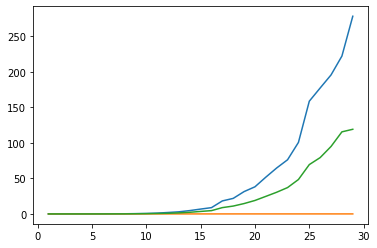

In [46]:
plt.plot(range(1,30), s_lm0_times)
plt.plot(range(1,30), mooney_times)
plt.plot(range(1,30), nation_times)
plt.title("time to mitigate GHZ states")

In [48]:
ignis_times = []
ignis_counts_list = []
for i in range(len(results_meas_cal[:10])):
    print(i + 1, "qubits")
    t1 = time.time()
    ignis_counts_list.append(
        ignis_mitigator_list[i].apply(counts_dict_list[i]))
    t2 = time.time()
    ignis_times.append(t2 - t1)
    print(t2-t1)
    print()


1 qubits
0.0012936592102050781

2 qubits
0.02447986602783203

3 qubits
0.027510881423950195

4 qubits
0.10572099685668945

5 qubits


/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


0.34834718704223633

6 qubits
1.6815669536590576

7 qubits
6.98108983039856

8 qubits
31.773523092269897

9 qubits
145.5711259841919

10 qubits
760.9569540023804



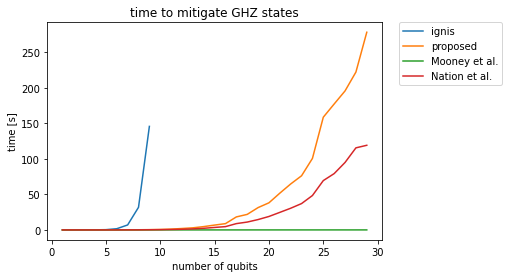

In [55]:
plt.plot(range(1, 10), ignis_times[:9], label="ignis")
plt.plot(range(1, 30), s_lm0_times, label="proposed")
plt.plot(range(1, 30), mooney_times, label = "Mooney et al.")
plt.plot(range(1, 30), nation_times, label="Nation et al.")
plt.title("time to mitigate GHZ states")
plt.xlabel("number of qubits")
plt.ylabel("time [s]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [58]:
with open("./pkls/brooklyn_all_times.pkl", "wb") as f:
    pickle.dump([ignis_times, s_lm0_times, mooney_times, nation_times], f)

In [59]:
with open("./pkls/brooklyn_all_counts_list.pkl", "wb") as f:
    pickle.dump([ignis_counts_list, s_lm0_times, mooney_counts_list, nation_counts_list], f)